In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

from copy import deepcopy
import itertools
import pickle

import pandas as pd
from scipy.io import savemat, loadmat
import seaborn as sns
from sklearn.metrics import (log_loss, mean_squared_error, roc_curve, auc,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from tqdm import tqdm, trange, tqdm_notebook as tqdmn

from BEKML import BEMKL, plot_distplot
from utils import poly_kernel, gauss_kernel, scoring, plot_kernel_importances, plot_compare_models

sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/pml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
data = pd.read_csv('data/sonar.csv', names=list(range(60)))
display(data.head())
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,0.734200,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


In [4]:
X = data.iloc[:, :-1].copy()
y = data.iloc[:, -1].copy()
N, D = X.shape
y.loc[y == 'R'] = -1
y.loc[y == 'M'] = 1
y = y.astype(int)
display(X.shape, y.shape, y.mean())

(208, 59)

(208,)

0.0673076923076923

In [5]:
proc_data = data.copy()
proc_data.iloc[:, -1] = y
proc_data.to_csv('data/proc_sonar.csv')

In [6]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 1, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 1, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(780, 780)

In [7]:
X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [8]:
normalizer = Normalizer()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.fit_transform(X_test)

# Baseline Model

In [10]:
max_iter = 200
base_model = BEMKL(kernels=kernels, hyp_lambda_alpha=1, hyp_lambda_beta=1,
                   hyp_gamma_alpha=1, hyp_gamma_beta=1,
                   hyp_omega_alpha=1, hyp_omega_beta=1,
                   e_null_thrsh=1e-2, a_null_thrsh=1e-2,
                   filter_kernels=False, filter_sv=False, verbose=False,
                   max_iter=max_iter, hyperopt_enabled=False, calculate_bounds=False)
base_pipeline = make_pipeline(Normalizer(), base_model)

In [7]:
scoring.iteration = 0
scoring.stats = []
folds = RepeatedStratifiedKFold(n_splits=4, n_repeats=5)
base_cv_results = cross_validate(base_pipeline, X, y, cv=folds, scoring=scoring)
base_stats = deepcopy(scoring.stats)
base_cv_results, base_stats

0 - Kernels: 190/780 (0.24358974358974358). SV: 151/155 (0.9741935483870968). Mean e: 0.0065. Median e: 0.0008. Std e: 0.0527. 
1 - Kernels: 13/780 (0.016666666666666666). SV: 154/156 (0.9871794871794872). Mean e: 0.0055. Median e: 0.0024. Std e: 0.0492. 
2 - Kernels: 13/780 (0.016666666666666666). SV: 149/156 (0.9551282051282052). Mean e: 0.0054. Median e: 0.0018. Std e: 0.0558. 
3 - Kernels: 13/780 (0.016666666666666666). SV: 153/157 (0.9745222929936306). Mean e: 0.0018. Median e: 0.0014. Std e: 0.0517. 
4 - Kernels: 13/780 (0.016666666666666666). SV: 153/155 (0.9870967741935484). Mean e: 0.0016. Median e: 0.0018. Std e: 0.0573. 
5 - Kernels: 190/780 (0.24358974358974358). SV: 152/156 (0.9743589743589743). Mean e: 0.0089. Median e: 0.0016. Std e: 0.0503. 
6 - Kernels: 190/780 (0.24358974358974358). SV: 149/156 (0.9551282051282052). Mean e: 0.0076. Median e: 0.0018. Std e: 0.0529. 
7 - Kernels: 180/780 (0.23076923076923078). SV: 151/157 (0.9617834394904459). Mean e: 0.0088. Median e: 

/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


({'fit_time': array([22.5015, 19.6866, 19.4603, 19.7254, 19.7749, 20.3587, 19.7135, 20.5889, 20.0396, 19.9047,
         19.9917, 20.1316, 20.1175, 19.515 , 19.5898, 20.4102, 19.6439, 19.8873, 19.7052, 19.7951]),
  'score_time': array([1.0111, 1.0025, 1.015 , 1.0214, 0.9973, 1.0093, 1.0088, 1.0312, 1.0103, 1.006 , 0.9995,
         1.0019, 1.0073, 1.0157, 1.0041, 0.9972, 1.0085, 1.0083, 0.9986, 1.0064]),
  'test_score': array([0.7358, 0.6731, 0.8077, 0.7843, 0.8679, 0.7308, 0.7885, 0.7451, 0.8302, 0.7885, 0.6538,
         0.7451, 0.8302, 0.7885, 0.7308, 0.7059, 0.7358, 0.75  , 0.7308, 0.7059]),
  'train_score': array([0.9097, 0.8718, 0.8654, 0.879 , 0.8581, 0.859 , 0.859 , 0.8854, 0.8516, 0.8462, 0.8846,
         0.8981, 0.8581, 0.8974, 0.8846, 0.9045, 0.8581, 0.8782, 0.8654, 0.8854])},
 [{'elapsed_time': 21.788711309432983,
   'nr_kernels_used': 190,
   'nr_sv_used': 151,
   'total_kernels': 780,
   'total_sv': 155},
  {'elapsed_time': 19.049602270126343,
   'nr_kernels_used': 13,
   'n

In [8]:
base_times = np.array([s['elapsed_time'] for s in base_stats])
base_kernels = np.array([s['nr_kernels_used'] for s in base_stats])
base_sv = np.array([s['nr_sv_used'] for s in base_stats])
print(
    f"Score: {base_cv_results['test_score'].mean()} +- {base_cv_results['test_score'].std()}\n"
    f"Time: {base_times.mean()} +- {base_times.std()}\n"
    f"Kernels: {base_kernels.mean()} +- {base_kernels.std()}\n"
    f"SVs: {base_sv.mean()} +- {base_sv.std()}"
)

Score: 0.7564291101055807 +- 0.052676919753813854
Time: 19.383955717086792 +- 0.6274612497908182
Kernels: 101.0 +- 88.02556446851108
SVs: 150.6 +- 2.177154105707724


# Kernel-sparse model

In [11]:
max_iter = 200
ksparse_model = BEMKL(kernels=kernels, hyp_lambda_alpha=1, hyp_lambda_beta=1,
                      hyp_gamma_alpha=1, hyp_gamma_beta=1,
                      hyp_omega_alpha=1e-11, hyp_omega_beta=1e9,
                      e_null_thrsh=1e-2, a_null_thrsh=1e-2,
                      filter_kernels=False, filter_sv=False, verbose=False,
                      max_iter=max_iter, hyperopt_enabled=False, calculate_bounds=False)
ksparse_pipeline = make_pipeline(Normalizer(), ksparse_model)

In [9]:
scoring.iteration = 0
scoring.stats = []
folds = RepeatedStratifiedKFold(n_splits=4, n_repeats=5)
ksparse_cv_results = cross_validate(ksparse_pipeline, X, y, cv=folds, scoring=scoring)
ksparse_stats = deepcopy(scoring.stats)
ksparse_cv_results, ksparse_stats

0 - Kernels: 1/780 (0.001282051282051282). SV: 150/155 (0.967741935483871). Mean e: 0.0029. Median e: 0.0000. Std e: 0.0817. 
1 - Kernels: 3/780 (0.0038461538461538464). SV: 149/156 (0.9551282051282052). Mean e: 0.0036. Median e: 0.0000. Std e: 0.0585. 
2 - Kernels: 1/780 (0.001282051282051282). SV: 152/156 (0.9743589743589743). Mean e: 0.0028. Median e: -0.0000. Std e: 0.0777. 
3 - Kernels: 3/780 (0.0038461538461538464). SV: 150/157 (0.9554140127388535). Mean e: 0.0037. Median e: 0.0000. Std e: 0.0598. 
4 - Kernels: 1/780 (0.001282051282051282). SV: 152/155 (0.9806451612903225). Mean e: 0.0035. Median e: 0.0000. Std e: 0.0957. 
5 - Kernels: 1/780 (0.001282051282051282). SV: 149/156 (0.9551282051282052). Mean e: 0.0029. Median e: 0.0000. Std e: 0.0812. 
6 - Kernels: 3/780 (0.0038461538461538464). SV: 154/156 (0.9871794871794872). Mean e: 0.0031. Median e: 0.0000. Std e: 0.0541. 
7 - Kernels: 3/780 (0.0038461538461538464). SV: 154/157 (0.9808917197452229). Mean e: 0.0036. Median e: -0.0

/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


({'fit_time': array([20.0555, 19.5807, 19.3477, 19.6175, 20.1481, 19.7658, 20.1337, 19.6782, 19.8392, 19.4638,
         19.6817, 19.9873, 19.6656, 19.3801, 19.7813, 19.5155, 19.962 , 19.6366, 19.5675, 19.3627]),
  'score_time': array([1.0144, 0.9959, 0.9982, 0.9981, 1.0073, 0.9988, 1.011 , 1.0006, 1.0148, 1.0384, 1.0066,
         1.0082, 1.0012, 1.0003, 1.0086, 1.0092, 1.0045, 1.0085, 1.0037, 1.0054]),
  'test_score': array([0.8113, 0.8077, 0.6923, 0.8039, 0.7547, 0.8462, 0.6346, 0.7451, 0.7925, 0.75  , 0.7308,
         0.8039, 0.7736, 0.7885, 0.7692, 0.6863, 0.7925, 0.8462, 0.6731, 0.7843]),
  'train_score': array([0.8129, 0.8782, 0.8654, 0.8917, 0.8774, 0.8526, 0.8846, 0.8854, 0.871 , 0.891 , 0.8654,
         0.8854, 0.8968, 0.8654, 0.9231, 0.8662, 0.9032, 0.8654, 0.9359, 0.8344])},
 [{'elapsed_time': 19.4315288066864,
   'nr_kernels_used': 1,
   'nr_sv_used': 150,
   'total_kernels': 780,
   'total_sv': 155},
  {'elapsed_time': 18.92827033996582,
   'nr_kernels_used': 3,
   'nr_sv_u

In [10]:
ksparse_times = np.array([s['elapsed_time'] for s in ksparse_stats])
ksparse_kernels = np.array([s['nr_kernels_used'] for s in ksparse_stats])
ksparse_sv = np.array([s['nr_sv_used'] for s in ksparse_stats])
print(
    f"Score: {ksparse_cv_results['test_score'].mean()} +- {ksparse_cv_results['test_score'].std()}\n"
    f"Time: {ksparse_times.mean()} +- {ksparse_times.std()}\n"
    f"Kernels: {ksparse_kernels.mean()} +- {ksparse_kernels.std()}\n"
    f"SVs: {ksparse_sv.mean()} +- {ksparse_sv.std()}"
)

Score: 0.7643259626056519 +- 0.05545883945568049
Time: 19.069387578964232 +- 0.2464497400433245
Kernels: 2.4 +- 0.9165151389911679
SVs: 151.5 +- 2.3130067012440754


# SV-sparse model

In [12]:
max_iter = 200
ssparse_model = BEMKL(kernels=kernels,
                      hyp_lambda_alpha=1e-11, hyp_lambda_beta=1e9,
                      hyp_gamma_alpha=1, hyp_gamma_beta=1,
                      hyp_omega_alpha=1, hyp_omega_beta=1,
                      e_null_thrsh=1e-2, a_null_thrsh=1e-2,
                      filter_kernels=False, filter_sv=False, verbose=False,
                      max_iter=max_iter, hyperopt_enabled=False, calculate_bounds=False)
ssparse_pipeline = make_pipeline(Normalizer(), ssparse_model)

In [11]:
scoring.iteration = 0
scoring.stats = []
folds = RepeatedStratifiedKFold(n_splits=4, n_repeats=5)
ssparse_cv_results = cross_validate(ssparse_pipeline, X, y, cv=folds, scoring=scoring)
ssparse_stats = deepcopy(scoring.stats)
ssparse_cv_results, ssparse_stats

0 - Kernels: 190/780 (0.24358974358974358). SV: 27/155 (0.17419354838709677). Mean e: 0.0140. Median e: 0.0023. Std e: 0.0584. 
1 - Kernels: 190/780 (0.24358974358974358). SV: 35/156 (0.22435897435897437). Mean e: 0.0109. Median e: 0.0035. Std e: 0.0819. 
2 - Kernels: 13/780 (0.016666666666666666). SV: 28/156 (0.1794871794871795). Mean e: 0.0053. Median e: 0.0039. Std e: 0.0558. 
3 - Kernels: 13/780 (0.016666666666666666). SV: 25/157 (0.1592356687898089). Mean e: 0.0020. Median e: -0.0000. Std e: 0.0617. 
4 - Kernels: 13/780 (0.016666666666666666). SV: 28/155 (0.18064516129032257). Mean e: 0.0040. Median e: 0.0005. Std e: 0.0680. 
5 - Kernels: 13/780 (0.016666666666666666). SV: 26/156 (0.16666666666666666). Mean e: 0.0046. Median e: -0.0003. Std e: 0.0697. 
6 - Kernels: 190/780 (0.24358974358974358). SV: 29/156 (0.1858974358974359). Mean e: 0.0089. Median e: 0.0028. Std e: 0.0756. 
7 - Kernels: 190/780 (0.24358974358974358). SV: 28/157 (0.17834394904458598). Mean e: 0.0061. Median e: 0

/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


({'fit_time': array([19.756 , 19.6139, 19.4382, 19.3437, 19.8024, 19.3236, 19.5283, 19.5385, 19.4687, 19.7547,
         20.0042, 19.7636, 20.2678, 19.4149, 19.3505, 19.535 , 19.3943, 19.7598, 19.3758, 19.4638]),
  'score_time': array([1.0031, 1.0189, 1.0176, 1.0106, 1.0079, 1.0233, 1.0046, 1.0096, 1.0394, 1.0065, 1.0187,
         1.0092, 1.0056, 1.0061, 1.0172, 1.0682, 1.0074, 1.0069, 1.0024, 1.0175]),
  'test_score': array([0.7925, 0.7308, 0.7885, 0.7647, 0.717 , 0.8462, 0.8462, 0.8627, 0.8302, 0.8077, 0.7115,
         0.7843, 0.6604, 0.8077, 0.7115, 0.8235, 0.7925, 0.8654, 0.7308, 0.7451]),
  'train_score': array([0.9097, 0.9359, 0.8718, 0.9299, 0.9226, 0.9038, 0.9359, 0.9045, 0.9226, 0.8782, 0.9295,
         0.9363, 0.9161, 0.9551, 0.8974, 0.9108, 0.8903, 0.9038, 0.9167, 0.9299])},
 [{'elapsed_time': 19.101150512695312,
   'nr_kernels_used': 190,
   'nr_sv_used': 27,
   'total_kernels': 780,
   'total_sv': 155},
  {'elapsed_time': 18.977724313735962,
   'nr_kernels_used': 190,
   'n

In [12]:
ssparse_times = np.array([s['elapsed_time'] for s in ssparse_stats])
ssparse_kernels = np.array([s['nr_kernels_used'] for s in ssparse_stats])
ssparse_sv = np.array([s['nr_sv_used'] for s in ssparse_stats])
print(
    f"Score: {ssparse_cv_results['test_score'].mean()} +- {ssparse_cv_results['test_score'].std()}\n"
    f"Time: {ssparse_times.mean()} +- {ssparse_times.std()}\n"
    f"Kernels: {ssparse_kernels.mean()} +- {ssparse_kernels.std()}\n"
    f"SVs: {ssparse_sv.mean()} +- {ssparse_sv.std()}"
)

Score: 0.7809499416602634 +- 0.056202315045259556
Time: 18.950484240055083 +- 0.2406851241635407
Kernels: 101.5 +- 88.5
SVs: 28.5 +- 2.539685019840059


In [13]:
import json
with open('sonar_results.json', 'w') as fp:
    json.dump(
        {
            'ksparse': {
                'scores': list(ksparse_cv_results['test_score']),
                'times': list(ksparse_times),
                'kernels': [int(k) for k in ksparse_kernels],
                'svs': [int(s) for s in ksparse_sv],
            },
            'ssparse': {
                'scores': list(ssparse_cv_results['test_score']),
                'times': list(ssparse_times),
                'kernels': [int(k) for k in ksparse_kernels],
                'svs': [int(s) for s in ssparse_sv],
            },
            'base': {
                'scores': list(base_cv_results['test_score']),
                'times': list(base_times),
                'kernels': [int(k) for k in base_kernels],
                'svs': [int(s) for s in base_sv],
            },
            'total_kernels': len(kernels),
            'total_sv': len(X_train),
        },
        fp,
        indent=4,
        sort_keys=True
    )

# $e_\mu$ and $a_\mu$ distributions

In [13]:
base_pipeline.fit(X_train, y_train)
ksparse_pipeline.fit(X_train, y_train)
ssparse_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('normalizer', Normalizer(copy=True, norm='l2')), ('bemkl', BEMKL(a_null_thrsh=0.01, calculate_bounds=False, e_null_thrsh=0.01,
   filter_kernels=False, filter_sv=False, hyp_gamma_alpha=1,
   hyp_gamma_beta=1, hyp_lambda_alpha=1e-11, hyp_lambda_beta=1000000000.0,
   hyp_omega_alpha=1, hyp_ome...da> at 0x7ff81d0afb70>],
   margin=1, max_iter=200, random_state=None, sigma_g=0.1, verbose=False))])

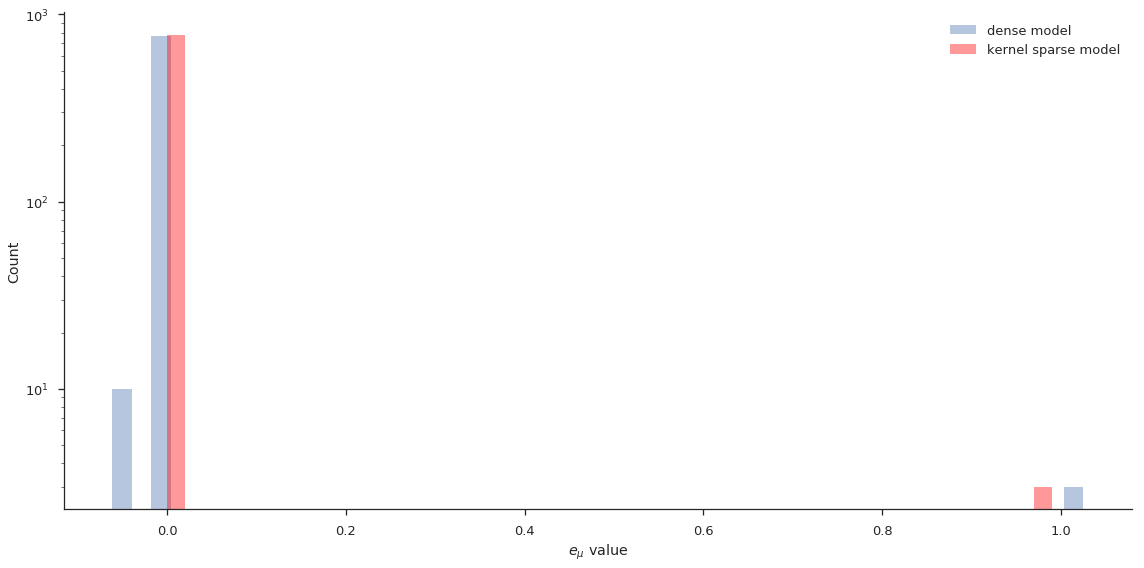

In [14]:
ax1 = plt.figure(figsize=(16, 8)).gca()
_, ax2 = base_model.plot_e(ax1=ax1, label='dense model', plotdist=False)
ksparse_model.plot_e(ax1=ax1, ax2=ax2, label='kernel sparse model', color='r', plotdist=False)
ax1.set_yscale('log', nonposy='clip')
ax1.legend()
sns.despine()
plt.tight_layout()

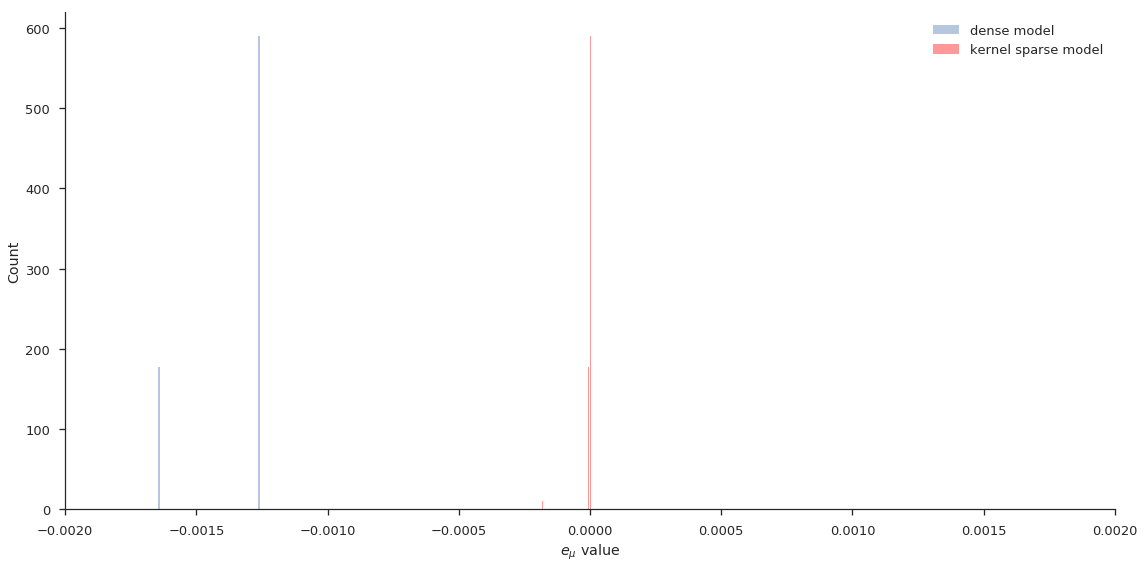

In [37]:
ax1 = plt.figure(figsize=(16, 8)).gca()
val_lim = 0.002
_, ax2 = base_model.plot_e(ax1=ax1, label='dense model', max_data=val_lim, min_data=-val_lim, plotdist=False)
ksparse_model.plot_e(ax1=ax1, ax2=ax2, label='kernel sparse model', color='r', max_data=val_lim, min_data=-val_lim, plotdist=False)
ax1.set_xlim(-val_lim, val_lim)
ax1.legend()
sns.despine()
plt.tight_layout()

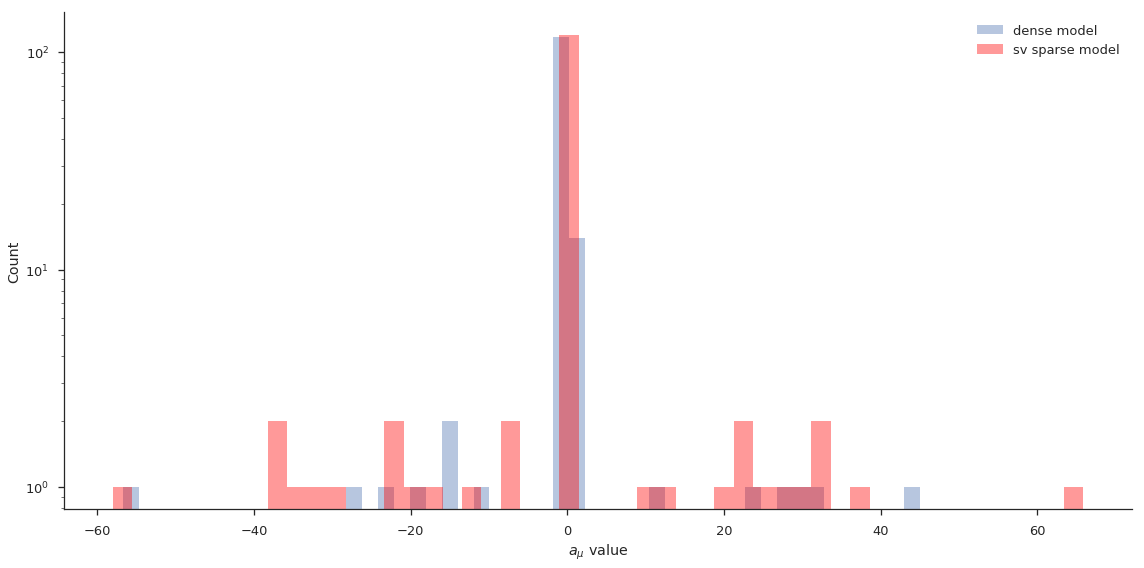

In [27]:
ax1 = plt.figure(figsize=(16, 8)).gca()
_, ax2 = base_model.plot_a(ax1=ax1, label='dense model', plotdist=False)
ssparse_model.plot_a(ax1=ax1, ax2=ax2, label='sv sparse model', color='r', plotdist=False)
ax1.set_yscale('log', nonposy='clip')
ax1.legend()
sns.despine()
plt.tight_layout()

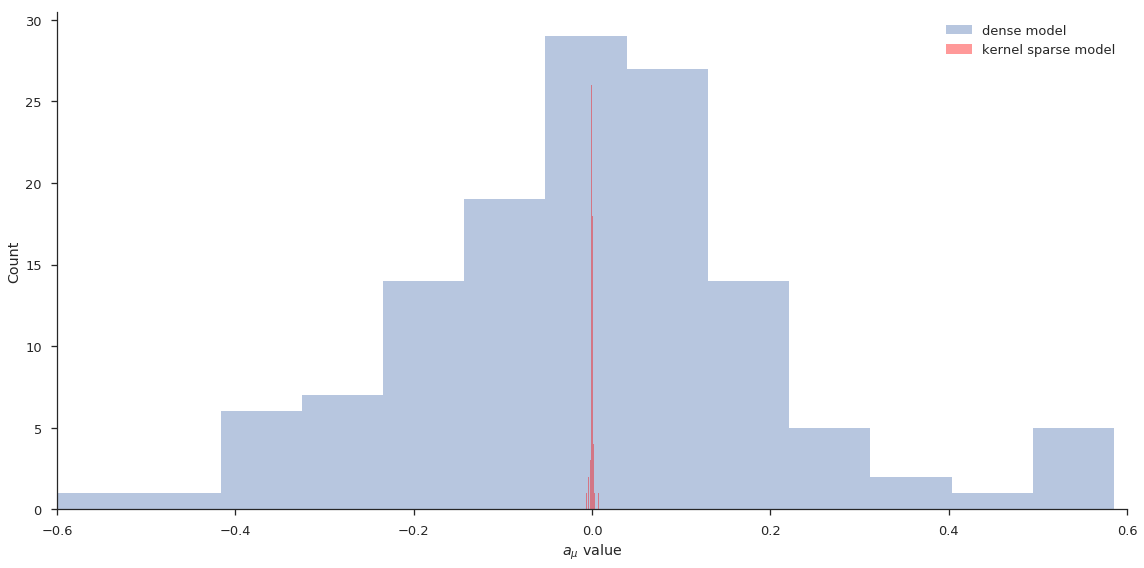

In [38]:
ax1 = plt.figure(figsize=(16, 8)).gca()
val_lim = 0.6
_, ax2 = base_model.plot_a(ax1=ax1, label='dense model', max_data=val_lim, min_data=-val_lim, plotdist=False)
ssparse_model.plot_a(ax1=ax1, ax2=ax2, label='kernel sparse model', color='r', max_data=val_lim, min_data=-val_lim, plotdist=False)
ax1.set_xlim(-val_lim, val_lim)
ax1.legend()
sns.despine()
plt.tight_layout()